In [1]:
# !pip install opencv-python
# !pip3 install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [2]:
import sys
import os

from numpy.lib.npyio import save

datapath = "data/"
pic_path = datapath + "img_align_celeba/img_align_celeba"

try:
    os.makedirs("data/attr/")
except FileExistsError:
    pass

import cv2
import glob
import yaml
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import pandas as pd
from IPython.display import display

In [3]:
batch_size = 8

In [4]:
attr_celeba = pd.read_csv(datapath+"list_attr_celeba.csv").set_index("image_id")
attr_celeba_eval_part = pd.read_csv(datapath+"list_eval_partition.csv").set_index("image_id")
attr_celeba_join = attr_celeba.join(attr_celeba_eval_part, on="image_id").reset_index()
attr_celeba_join[attr_celeba_join["partition"]==0].drop("partition", axis=1).set_index("image_id").to_csv("data/attr/"+"train.csv")
attr_celeba_join[attr_celeba_join["partition"]==1].drop("partition", axis=1).set_index("image_id").to_csv("data/attr/"+"test.csv")
attr_celeba_join[attr_celeba_join["partition"]==2].drop("partition", axis=1).set_index("image_id").to_csv("data/attr/"+"val.csv")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


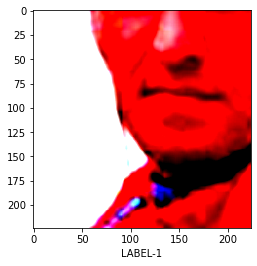

20347


In [5]:
# 定义数据的处理方式
data_transforms = {
    'train': transforms.Compose([
        # 将图像进行缩放，缩放为256*256
        transforms.Resize(256),
        # 在256*256的图像上随机裁剪出224*224大小的图像用于训练
        transforms.RandomResizedCrop(224),
        # 图像用于翻转
        transforms.RandomHorizontalFlip(),
        # 转换成tensor向量
        transforms.ToTensor(),
        # 对图像进行归一化操作
        # [0.485, 0.456, 0.406]，RGB通道的均值与标准差
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    # 测试集需要中心裁剪，甚至不裁剪，直接缩放为224*224for，不需要翻转
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# 定义数据读入
def Load_Image_Information(path):
    # 图像存储路径
    image_Root_Dir = pic_path
    # 获取图像的路径
    iamge_Dir = os.path.join(image_Root_Dir, path)
    # 以RGB格式打开图像
    # Pytorch DataLoader就是使用PIL所读取的图像格式
    # 建议就用这种方法读取图像，当读入灰度图像时convert('')
    return Image.open(iamge_Dir).convert('RGB')


# 定义自己数据集的数据读入类
class my_Data_Set(nn.Module):
    def __init__(self, csv, transform=None, target_transform=None, loader=None):
        super(my_Data_Set, self).__init__()
        fp = open(csv, 'r')
        images = []
        labels = []

        counter = 0
        for line in fp:
            if counter != 0:
                line.strip('\n')
                line.rstrip()
                information = line.split(",")
                images.append(information[0])
                labels.append(int(information[1]))
            counter += 1
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    # 重写这个函数用来进行图像数据的读取
    def __getitem__(self, item):
        # 获取图像名和标签
        imageName = self.images[item]
        label = self.labels[item]
        # 读入图像信息
        image = self.loader(imageName)
        # 处理图像数据
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    # 重写这个函数，来看数据集中含有多少数据
    def __len__(self):
        return len(self.images)


# 生成Pytorch所需的DataLoader数据输入格式
train_Data = my_Data_Set("data/attr/"+"train.csv", transform=data_transforms['train'], loader=Load_Image_Information)
test_Data  = my_Data_Set("data/attr/"+"train.csv", transform=data_transforms['test'] , loader=Load_Image_Information)
val_Data   = my_Data_Set("data/attr/"+"val.csv"  , transform=data_transforms['val']  , loader=Load_Image_Information)

train_DataLoader = DataLoader(train_Data, batch_size=batch_size, shuffle=True)
test_DataLoader  = DataLoader(test_Data,  batch_size=batch_size, shuffle=True)
val_DataLoader   = DataLoader(val_Data,   batch_size=batch_size, shuffle=True)

# 验证是否生成DataLoader格式数据

for data in train_DataLoader:
    inputs, labels = data
    # print(inputs)
    # print(labels)
    img = inputs[0]
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    plt.imshow(img, interpolation='nearest')
    plt.xlabel('LABEL'+str(int(labels[0])))
    plt.show()
    break
print(len(train_DataLoader))
# for data in test_DataLoader:
#     inputs, labels = data
#     print(inputs)
#     print(labels)
    
# for data in val_DataLoader:
#     inputs, labels = data
#     print(inputs)
#     print(labels)